In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tnrange, tqdm_notebook
import gc

In [2]:
sns.set_context('talk')

# Read the data

In [3]:
dfXtrain = pd.read_csv('preprocessed_csv/train_more.csv', index_col='id')
dfXtest = pd.read_csv('preprocessed_csv/test_more.csv', index_col='id')
dfYtrain = pd.read_csv('preprocessed_csv/y_train_more.csv', header=None, names=['INDEX', 'P_TARGET_FLAG'])

In [4]:
x_train = np.array(dfXtrain)
x_test = np.array(dfXtest)

y_train = np.array(dfYtrain['P_TARGET_FLAG'])

# Save routines

In [5]:
dfYtest = pd.DataFrame({'INDEX': dfXtest.index, 'P_TARGET_FLAG': np.zeros(x_test.shape[0])})
dfYtest.head()

,INDEX,P_TARGET_FLAG
0,3,0.0
1,9,0.0
2,10,0.0
3,18,0.0
4,21,0.0


In [6]:
def save_to_file(y, file_name):
    dfYtest['P_TARGET_FLAG'] = y
    dfYtest.to_csv('results/{}'.format(file_name), index=False)

# Train RF

In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

In [9]:
def get_score_list(X, y, clf, scorer):
    predictions = list()
    score = list()
    for i, tree in enumerate(clf.estimators_):
        proba = tree.predict_proba(X)[:, 1]
        predictions.append(proba)
        rf_prediction = np.mean(predictions, axis=0)
        score.append(scorer(y, rf_prediction))
    return score

In [8]:
x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [10]:
%%time

kwargs = {'n_estimators': 1000, 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 56}

clf = RFC(**kwargs)
clf.fit(x_subtrain, y_subtrain)

score = get_score_list(x_subtest, y_subtest, clf, roc_auc_score)

CPU times: user 29.2 s, sys: 1.85 s, total: 31.1 s
Wall time: 13.4 s


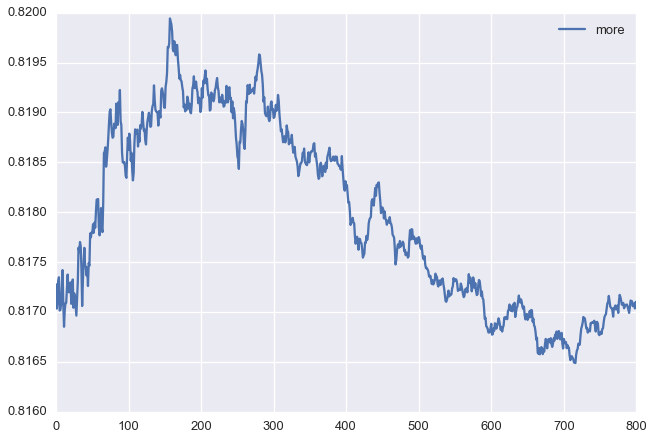

In [11]:
plt.plot(score[200:], label='more')
plt.legend()

In [12]:
x_train = np.array(dfXtrain.reset_index())
x_test = np.array(dfXtest.reset_index())

In [13]:
x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [14]:
%%time

kwargs = {'n_estimators': 1000, 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 56}

clf = RFC(**kwargs)
clf.fit(x_subtrain, y_subtrain)

score_index = get_score_list(x_subtest, y_subtest, clf, roc_auc_score)

CPU times: user 32.1 s, sys: 235 ms, total: 32.3 s
Wall time: 12.6 s


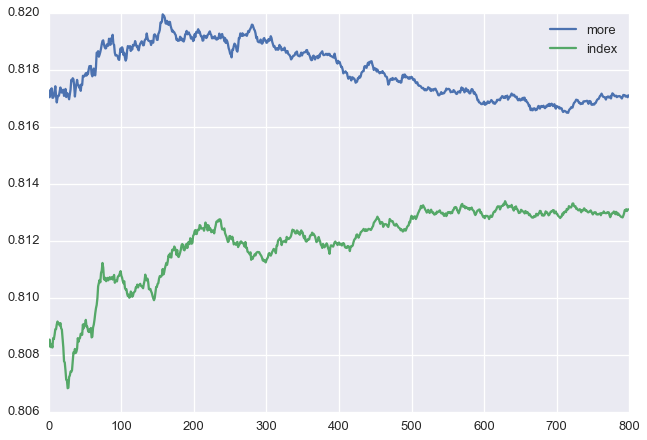

In [15]:
plt.plot(score[200:], label='more')
plt.plot(score_index[200:], label='index')
plt.legend()

Всё-таки индекс бесполезный признак

In [16]:
x_train = np.array(dfXtrain)
x_test = np.array(dfXtest)

In [17]:
x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [20]:
%%time

kwargs = {'n_estimators': 3000, 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 56}

clf = RFC(**kwargs)
clf.fit(x_train, y_train)

proba = clf.predict_proba(x_test)[:, 1]
save_to_file(proba, 'more_3000.csv')

CPU times: user 1min 33s, sys: 1.01 s, total: 1min 34s
Wall time: 28 s


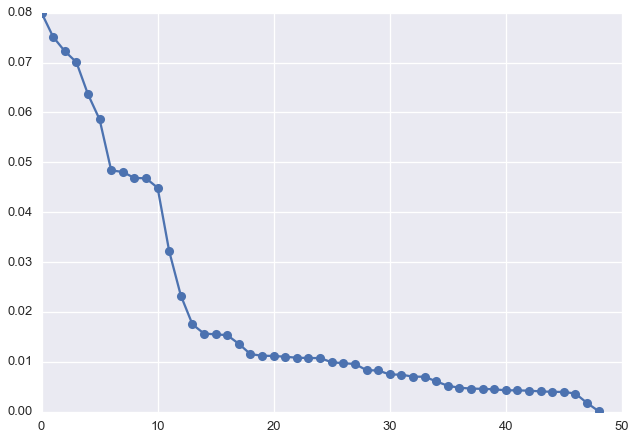

In [21]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.plot(importances[indices], '-o')

In [22]:
np.array(dfXtrain.columns.tolist())[indices[:11]]

array(['bluebook', 'income', 'travtime', 'age', 'home_val', 'oldclaim',
       'mvr_pts', 'car_age', 'yoj', 'urbanicity_z_Highly Rural/ Rural',
       'tif'], 
      dtype='<U32')

In [23]:
np.array(dfXtrain.columns.tolist())[indices[11:20]]

array(['clm_freq', 'homekids', 'car_use_Private', 'revoked_Yes',
       'car_type_Minivan', 'kidsdriv', 'mstatus_z_No',
       'education_z_High School', 'job_Manager'], 
      dtype='<U32')

### Поперебираем подможества признаков

#### numeric

In [26]:
dfXtrain.iloc[:,:13].head()

,travtime,homekids,tif,income,bluebook,clm_freq,oldclaim,car_age,home_val,age,kidsdriv,yoj,mvr_pts
id,,,,,,,,,,,,,
1,14,0,11,67349.0,14230.0,2,4461.0,18.0,0.0,60.0,0,11.0,3
2,22,0,1,91449.0,14940.0,0,0.0,1.0,257252.0,43.0,0,11.0,0
4,5,1,4,16039.0,4010.0,2,38690.0,10.0,124191.0,35.0,0,10.0,3
5,32,0,7,-1.0,15440.0,0,0.0,6.0,306251.0,51.0,0,14.0,0
6,36,0,1,114986.0,18000.0,2,19217.0,17.0,243925.0,50.0,0,-1.0,3


In [27]:
x_train = np.array(dfXtrain.iloc[:,:13])
x_test = np.array(dfXtest.iloc[:,:13])

x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [28]:
score_dict = {'all': score}

In [134]:
def score_subset():

    kwargs = {'n_estimators': 1000, 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 56}

    clf = RFC(**kwargs)
    clf.fit(x_subtrain, y_subtrain)

    return get_score_list(x_subtest, y_subtest, clf, roc_auc_score)

In [33]:
%%time
score_dict['numeric'] = score_subset()

CPU times: user 33.5 s, sys: 165 ms, total: 33.7 s
Wall time: 13 s


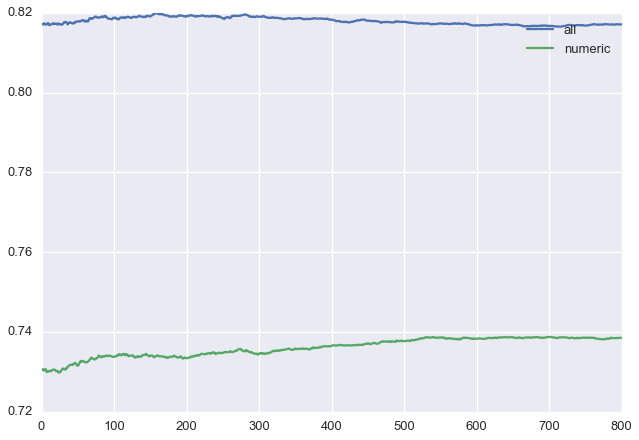

In [35]:
for name, score_list in score_dict.items():
    plt.plot(score_list[200:], label=name)
plt.legend()

#### numeric + categorical

In [43]:
cols = ['yoj_nan',
 'income_nan',
 'home_val_nan',
 'age_nan',
 'car_age_nan',
 'car_age_ano',
 'yoj_ano',
 'home_val_ano',
 'income_ano']
cols = list(set(dfXtrain.columns.tolist()) - set(cols))

In [45]:
x_train = np.array(dfXtrain[cols])
x_test = np.array(dfXtest[cols])

x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [46]:
%%time
score_dict['without_nan_ano'] = score_subset()

CPU times: user 28.6 s, sys: 136 ms, total: 28.7 s
Wall time: 11.6 s


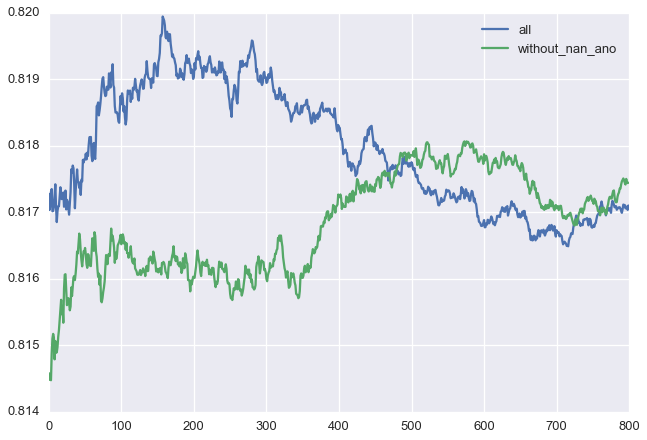

In [49]:
for name, score_list in score_dict.items():
    if name != 'numeric':
        plt.plot(score_list[200:], label=name)
plt.legend()

#### numeric + categorical + nan

In [50]:
cols = [
 'car_age_ano',
 'yoj_ano',
 'home_val_ano',
 'income_ano']
cols = list(set(dfXtrain.columns.tolist()) - set(cols))

In [51]:
x_train = np.array(dfXtrain[cols])
x_test = np.array(dfXtest[cols])

x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [52]:
%%time
score_dict['without_ano'] = score_subset()

CPU times: user 27.8 s, sys: 248 ms, total: 28 s
Wall time: 12.6 s


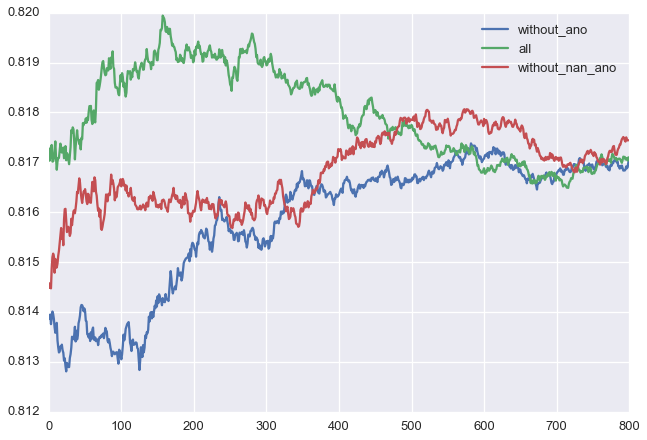

In [53]:
for name, score_list in score_dict.items():
    if name != 'numeric':
        plt.plot(score_list[200:], label=name)
plt.legend()

#### numeric + categorical + ano

In [54]:
cols = ['yoj_nan',
 'income_nan',
 'home_val_nan',
 'age_nan',
 'car_age_nan']
cols = list(set(dfXtrain.columns.tolist()) - set(cols))

In [55]:
x_train = np.array(dfXtrain[cols])
x_test = np.array(dfXtest[cols])

x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [56]:
%%time
score_dict['without_nan'] = score_subset()

CPU times: user 27.7 s, sys: 233 ms, total: 28 s
Wall time: 11.3 s


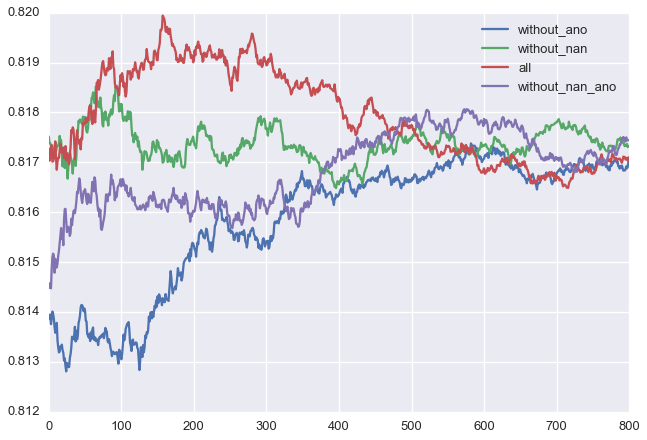

In [57]:
for name, score_list in score_dict.items():
    if name != 'numeric':
        plt.plot(score_list[200:], label=name)
plt.legend()

#### top most important

In [60]:
dfXtrain.iloc[:, indices[:40]].head()

,bluebook,income,travtime,age,home_val,oldclaim,mvr_pts,car_age,yoj,urbanicity_z_Highly Rural/ Rural,...,education_<High School,job_Clerical,education_Masters,job_Professional,car_type_Van,job_Student,car_age_nan,job_Lawyer,education_PhD,yoj_nan
id,,,,,,,,,,,,,,,,,,,,,
1,14230.0,67349.0,14,60.0,0.0,4461.0,3,18.0,11.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,1.0,0
2,14940.0,91449.0,22,43.0,257252.0,0.0,0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
4,4010.0,16039.0,5,35.0,124191.0,38690.0,3,10.0,10.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
5,15440.0,-1.0,32,51.0,306251.0,0.0,0,6.0,14.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0
6,18000.0,114986.0,36,50.0,243925.0,19217.0,3,17.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0,1


In [105]:
top = 10

x_train = np.array(dfXtrain.iloc[:, indices[:top]])
x_test = np.array(dfXtest.iloc[:, indices[:top]])

x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [106]:
%%time
score_dict['top' + str(top)] = score_subset()

CPU times: user 36.4 s, sys: 128 ms, total: 36.5 s
Wall time: 13.3 s


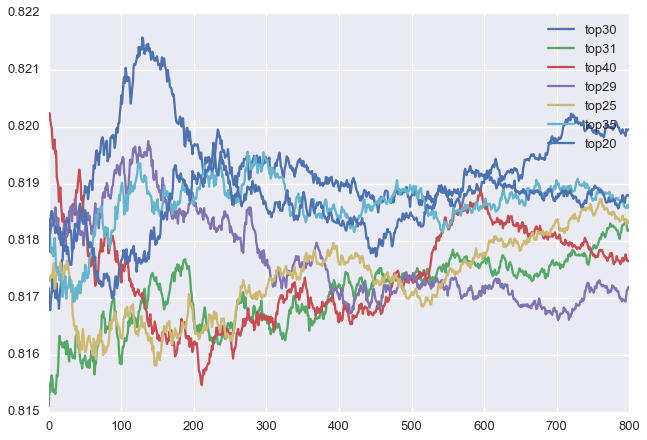

In [108]:
for name, score_list in score_dict.items():
    if name.startswith('top') and name != 'top10':
        plt.plot(score_list[200:], label=name)
plt.legend()

In [109]:
dfXtrain.columns.tolist()[indices[29]]

'car_type_Sports Car'

#### Селекция

In [102]:
dfXtrain.columns

Index(['travtime', 'homekids', 'tif', 'income', 'bluebook', 'clm_freq',
       'oldclaim', 'car_age', 'home_val', 'age', 'kidsdriv', 'yoj', 'mvr_pts',
       'yoj_nan', 'income_nan', 'home_val_nan', 'age_nan', 'car_age_nan',
       'car_age_ano', 'yoj_ano', 'home_val_ano', 'income_ano', 'parent1_Yes',
       'mstatus_z_No', 'sex_z_F', 'car_use_Private', 'red_car_yes',
       'revoked_Yes', 'urbanicity_z_Highly Rural/ Rural', 'job_Clerical',
       'job_Doctor', 'job_Home Maker', 'job_Lawyer', 'job_Manager',
       'job_Other', 'job_Professional', 'job_Student', 'job_z_Blue Collar',
       'education_<High School', 'education_Bachelors', 'education_Masters',
       'education_PhD', 'education_z_High School', 'car_type_Minivan',
       'car_type_Panel Truck', 'car_type_Pickup', 'car_type_Sports Car',
       'car_type_Van', 'car_type_z_SUV'],
      dtype='object')

In [111]:
mycols = np.array(dfXtrain.columns.tolist())[indices[:10]]
mycols = list(mycols)
mycols += ['car_type_Sports Car']
mycols

['bluebook',
 'income',
 'travtime',
 'age',
 'home_val',
 'oldclaim',
 'mvr_pts',
 'car_age',
 'yoj',
 'urbanicity_z_Highly Rural/ Rural',
 'car_type_Sports Car']

In [112]:
x_train = np.array(dfXtrain[mycols])
x_test = np.array(dfXtest[mycols])

x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [113]:
%%time
score_dict['10 first + sports_car'] = score_subset()

CPU times: user 34.6 s, sys: 156 ms, total: 34.8 s
Wall time: 12.8 s


In [116]:
stoplist = set(['top10', 'numeric', '10 first + sports_car'])

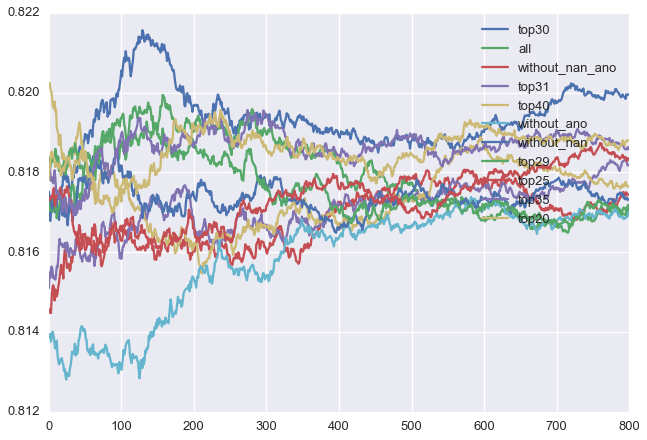

In [117]:
for name, score_list in score_dict.items():
    if name not in stoplist:
        plt.plot(score_list[200:], label=name)
plt.legend()

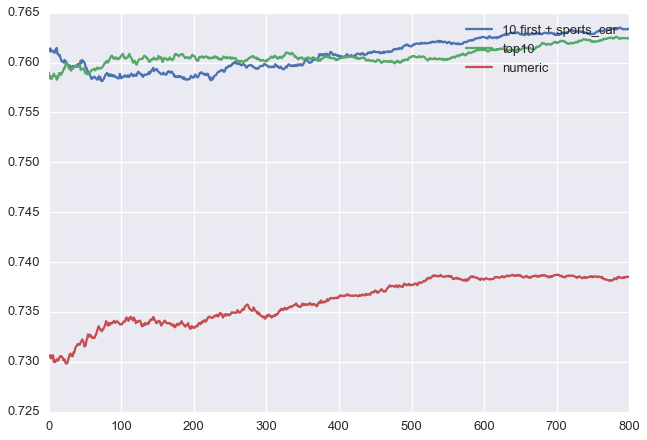

In [118]:
for name, score_list in score_dict.items():
    if name in stoplist:
        plt.plot(score_list[200:], label=name)
plt.legend()

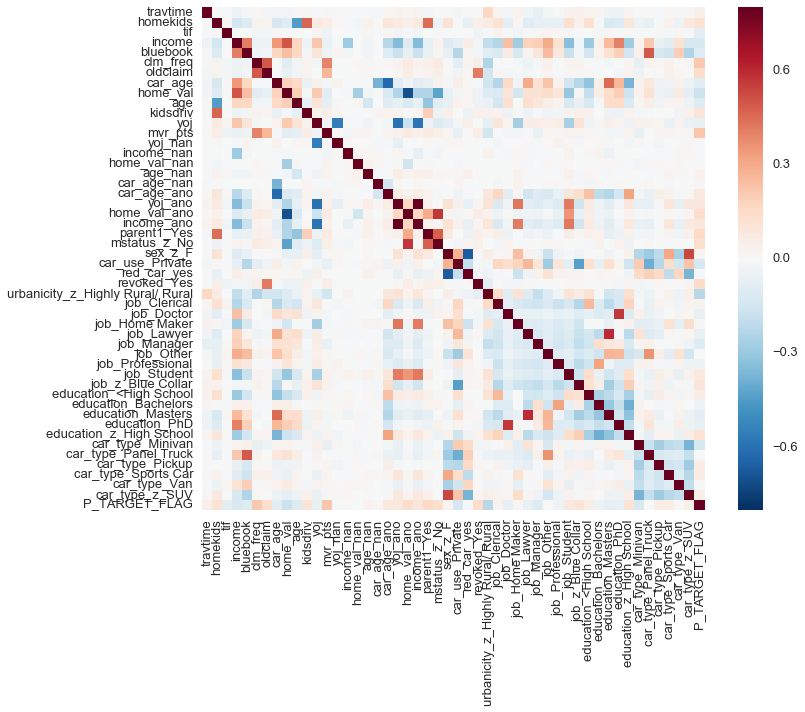

In [132]:
df = pd.concat([dfXtrain, dfYtrain.set_index('INDEX')], axis=1)
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, vmax=.8, square=True)


In [139]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

In [161]:
best_k = 33

selector = SelectKBest(f_classif, k=best_k).fit(np.array(dfXtrain), y_train)

x_train = selector.transform(np.array(dfXtrain))
x_test = selector.transform(np.array(dfXtest))

x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [162]:
%%time
score_dict['best' + str(best_k)] = score_subset()

CPU times: user 26.9 s, sys: 236 ms, total: 27.1 s
Wall time: 11.3 s


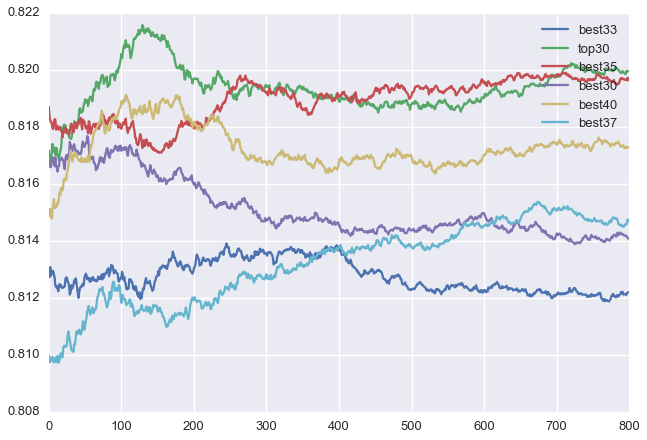

In [163]:
for name, score_list in score_dict.items():
    if name not in stoplist and (name == 'top30' or name.startswith('best')):
        plt.plot(score_list[200:], label=name)
plt.legend()

In [174]:
stoplist = set(['top10', 'numeric', '10 first + sports_car', 'best10'])

#### Выкинем несколько признаков, которые кореллируют с другими

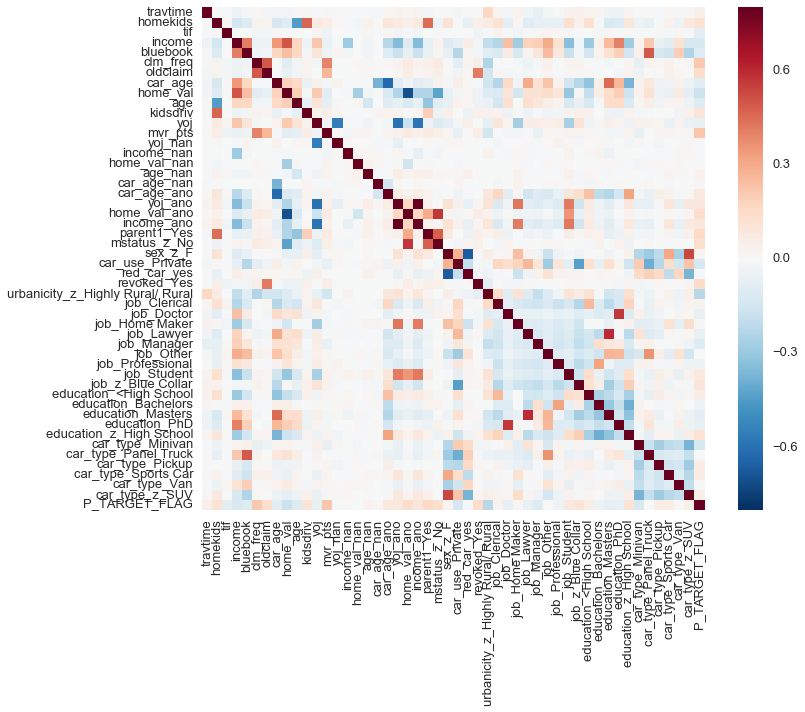

In [175]:
df = pd.concat([dfXtrain, dfYtrain.set_index('INDEX')], axis=1)
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, vmax=.8, square=True)


In [197]:
cols = ['income', 'income_ano', 'income_nan', 'homekids', 'clm_freq', ]

In [198]:
x_train = np.array(dfXtrain.drop(cols, axis=1))
x_test = np.array(dfXtest.drop(cols, axis=1))

x_subtrain, x_subtest, y_subtrain, y_subtest = train_test_split(x_train, y_train, 
                                                                test_size=0.15, random_state=42,
                                                                stratify=y_train)

In [199]:
%%time
score_dict['drop'] = score_subset()

CPU times: user 25.6 s, sys: 135 ms, total: 25.7 s
Wall time: 10.8 s


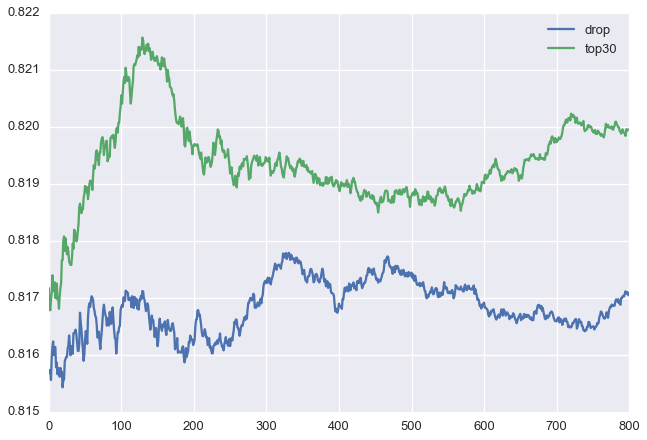

In [200]:
plt.plot(score_dict['drop'][200:], label='drop')
plt.plot(score_dict['top30'][200:], label='top30')
plt.legend()

Лучше не становится. Давайте попробуем top30

In [201]:
top = 30

x_train = np.array(dfXtrain.iloc[:, indices[:top]])
x_test = np.array(dfXtest.iloc[:, indices[:top]])

In [202]:
%%time

kwargs = {'n_estimators': 3000, 'criterion': 'entropy', 'n_jobs': -1, 'random_state': 56}

clf = RFC(**kwargs)
clf.fit(x_train, y_train)

proba = clf.predict_proba(x_test)[:, 1]
save_to_file(proba, 'more_30_3000.csv')

CPU times: user 1min 24s, sys: 1.48 s, total: 1min 26s
Wall time: 1min 58s
